In [1]:
import os
from IPython.display import clear_output


notebook_dir = "/home/balabaevvl/courses/project/FITS/src/"
os.chdir(notebook_dir)

GPUs = [
    "GPU-e83bd31b-fcb9-b8de-f617-2d717619413b",
    "GPU-5a9b7750-9f85-49a5-3aae-fe07b1b7661d",
    "GPU-fe2d8dfd-06f2-a5c4-a7fd-4a5f23947005",
    "GPU-0c320096-21ee-4060-8731-826ca2febfab",
    "GPU-baef952c-6609-aace-3b78-e4e07788d5de",
    "GPU-3979d65b-c238-4e9c-0c1c-1aa3f05c56a1",
    "GPU-6c76a2c5-5375-aa06-11d4-0fddfac30e91",
]
os.environ["CUDA_VISIBLE_DEVICES"] = f"{GPUs[2]}"

In [2]:
from fits.dataframes.download import DownloadDatasetAirQuality

DownloadDatasetAirQuality()

In [3]:
# import pandas as pd
# from fits.config import DatasetsPaths

# df = pd.read_csv(
#     DatasetsPaths.pm25.value,
#     index_col="datetime",
#     parse_dates=True,
# )

# df.head()

In [4]:
# from fits.data.dataset import ModelMode, DatasetAirQuality

# dataset = DatasetAirQuality(ModelMode.train)

# for sample in dataset:
#     break
# sample

In [5]:
import torch
from fits.modelling.framework import Train, Evaluate
from fits.dataframes.dataset import DatasetAirQuality
from fits.dataframes.dataloader import ForecastingDataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetAirQuality, batch_size=256  #!
)
normalization_stats = train_loader.dataset.normalization_stats

In [6]:
import math
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from torch import nn


def VisualizeForecastSample(
    evaluation_dir: str | Path,
    nsample: int = 10,
    n_features: int = 36,
    sample_index: int = 0,
    ncols: int = 4,
    figsize=(24, 36),
) -> None:
    """
    Plot a separate subplot for each feature in feature_index.
    """
    evaluation_dir = Path(evaluation_dir)
    generated_path = evaluation_dir / f"generated_outputs_nsample{nsample}.pk"

    with open(generated_path, "rb") as f:
        (
            forecasted_data,
            forecast_mask,
            observed_data,
            observed_mask,
            time_points,
            scaler_tensor,
            mean_tensor,
        ) = pickle.load(f)

    forecasted_data = forecasted_data.cpu()
    forecast_mask = forecast_mask.cpu()
    observed_data = observed_data.cpu()
    observed_mask = observed_mask.cpu()
    time_points = time_points.cpu()

    time_axis = time_points[sample_index].numpy()

    ncols = min(ncols, n_features)
    nrows = math.ceil(n_features / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten() if n_features > 1 else [axes]

    # ---- LOOP OVER FEATURES ----
    for ax, feat in zip(axes, range(n_features)):
        forecast_samples = forecasted_data[sample_index, :, :, feat]
        sample_mask = forecast_mask[sample_index, :, feat].bool()
        observed_series = observed_data[sample_index, :, feat]
        observed_series_mask = observed_mask[sample_index, :, feat].bool()

        # Median + intervals
        median = forecast_samples.median(dim=0).values
        lower, upper = torch.quantile(forecast_samples, torch.tensor([0.1, 0.9]), dim=0)

        # Mask missing
        median = median.masked_fill(~sample_mask, torch.nan)
        lower = lower.masked_fill(~sample_mask, torch.nan)
        upper = upper.masked_fill(~sample_mask, torch.nan)

        # Convert
        obs_mask_np = observed_series_mask.numpy()
        obs_series_np = observed_series.numpy()
        sample_mask_np = sample_mask.numpy()
        median_np = median.numpy()
        lower_np = lower.numpy()
        upper_np = upper.numpy()

        # ---- PLOTTING INTO ax ----
        ax.scatter(
            time_axis[obs_mask_np],
            obs_series_np[obs_mask_np],
            color="black",
            s=10,
            label="Observed",
        )
        ax.plot(time_axis, median_np, label="Median", color="tab:green")
        ax.fill_between(
            time_axis,
            lower_np,
            upper_np,
            where=sample_mask_np,
            alpha=0.3,
            color="tab:green",
            label="10–90%",
        )

        ax.set_title(f"Feature {feat}")
        ax.set_xlabel("Time step")
        ax.set_ylabel("Value")
        ax.grid(True)
        ax.legend()

    # Turn off unused axes if any
    for ax in axes[n_features:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def CalculateParams(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
EPOCHS = 200
NSAMPLE = 10

# CSDI

In [ ]:
from fits.modelling.CSDI.adapter import CSDIAdapter


csdi = CSDIAdapter().to(device)
print(f"Total params: {CalculateParams(csdi)}")

In [ ]:
Train(csdi, train_loader, valid_loader, epochs=EPOCHS)

In [ ]:
# model_foldername = "CSDIAdapter_20251209_100411"

# state = torch.load(
#     f"../data/models/training/{model_foldername}/model.pth",
#     map_location=device,
# )

# csdi.load_state_dict(state)
# csdi.to(device)

# clear_output()

In [ ]:
Evaluate(csdi, test_loader, normalization_stats, nsample=NSAMPLE)

In [ ]:
eval_foldername = "CSDIAdapter_20251209_143526"
VisualizeForecastSample(f"../data/models/evaluation/{eval_foldername}", nsample=NSAMPLE, sample_index=1)

# DiffusionTS

In [8]:
from fits.modelling.DiffusionTS.adapter import DiffusionTSAdapter


diffusionts = DiffusionTSAdapter().to(device)
print(f"Total params: {CalculateParams(diffusionts)}")

Total params: 596372


In [ ]:
Train(diffusionts, train_loader, valid_loader, epochs=EPOCHS)

In [9]:
model_foldername = "DiffusionTSAdapter_20251210_111915"

state = torch.load(
    f"../data/models/training/{model_foldername}/model.pth",
    map_location=device,
)

diffusionts.load_state_dict(state)
diffusionts.to(device)

clear_output()

In [ ]:
Evaluate(diffusionts, test_loader, normalization_stats, nsample=NSAMPLE)

  0%|                                                                                                                                                                    | 0/6 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

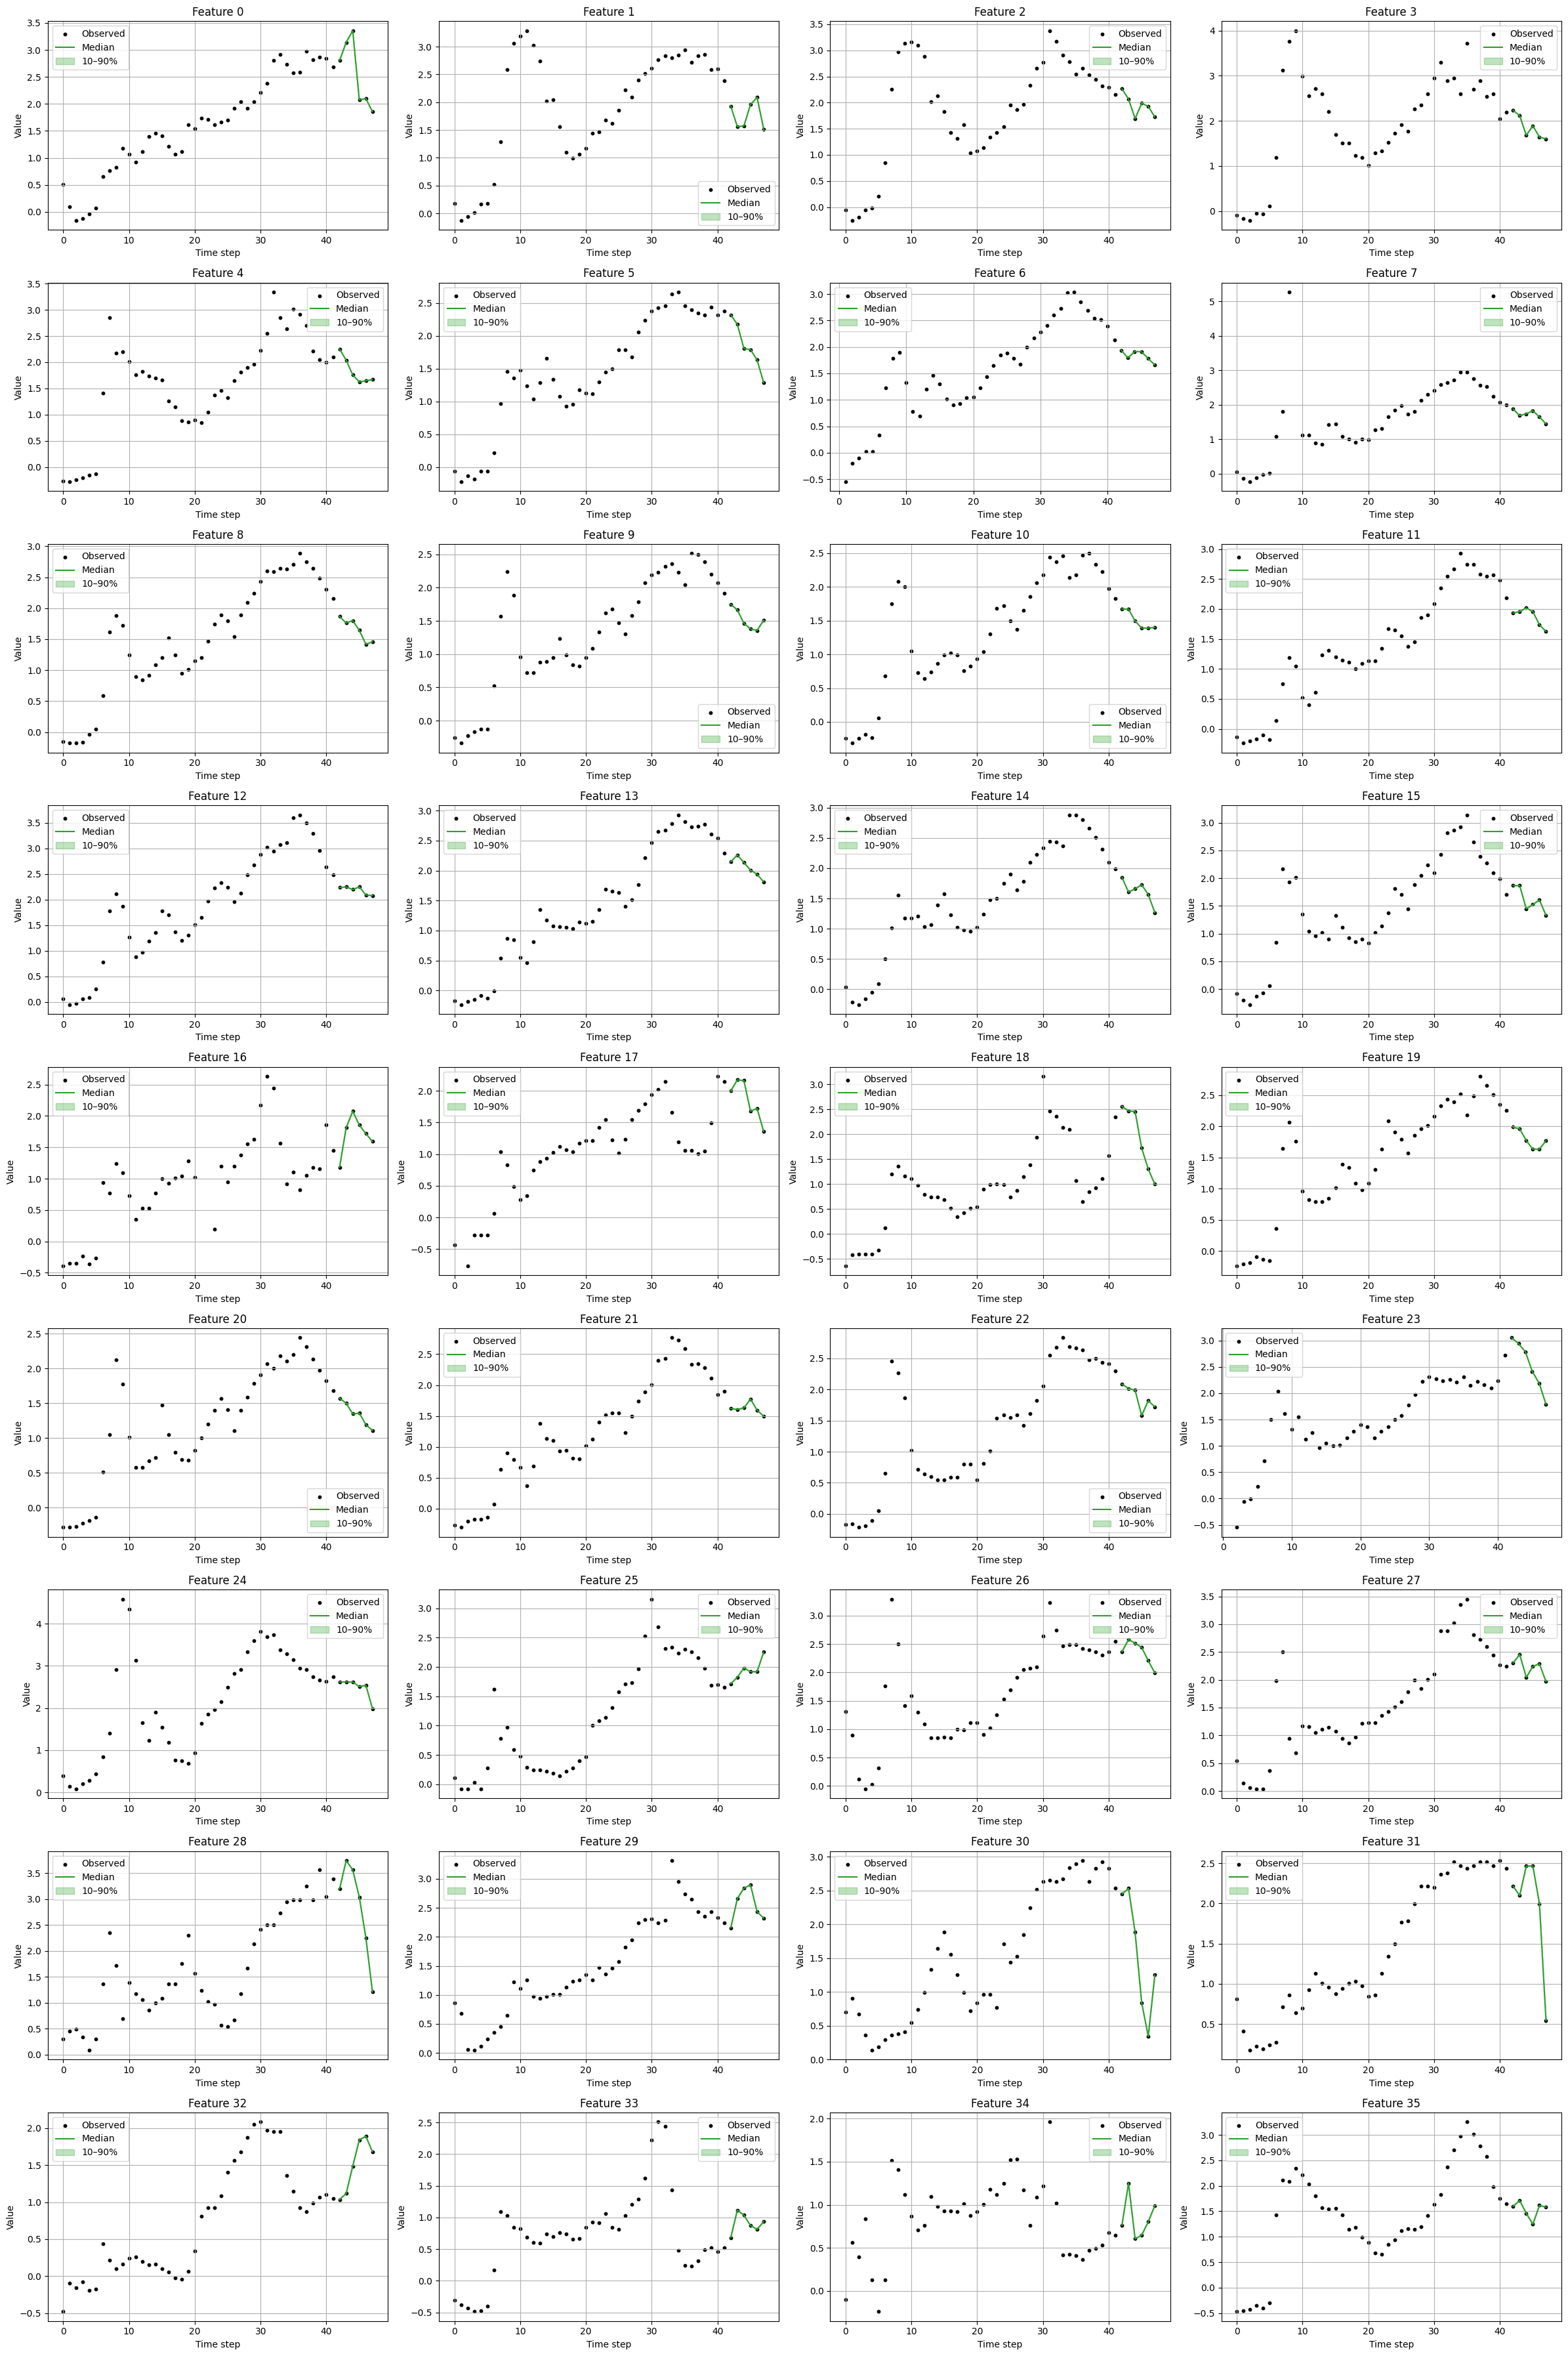

In [11]:
eval_foldername = "DiffusionTSAdapter_20251210_171124"
VisualizeForecastSample(f"../data/models/evaluation/{eval_foldername}", nsample=NSAMPLE, sample_index=1)

# FM-TS

In [ ]:
from fits.modelling.FMTS.adapter import FMTSAdapter


fmts = FMTSAdapter().to(device)
print(f"Total params: {CalculateParams(fmts)}")

In [ ]:
Train(fmts, train_loader, valid_loader, epochs=EPOCHS)

In [ ]:
Evaluate(fmts, test_loader, normalization_stats, nsample=NSAMPLE)

In [ ]:
# TODO: Comparison of truth VS forecasted in:
# PSA plot
# t-SNE plot
# Data Density